# Mask R-CNN - Inspect ShipTrained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io
import pandas as pd

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.ship import ship

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
SHIP_WEIGHTS_PATH = "./logs/ship20180815T0023/mask_rcnn_ship_0050.h5"  # TODO: update this path

Using TensorFlow backend.


## Configurations

In [3]:
config = ship.ShipConfig()
SHIP_DIR = os.path.join(ROOT_DIR, "./samples/ship/datasets")

In [64]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_NMS_THRESHOLD = 0.0
    DETECTION_MIN_CONFIDENCE = 0.95
    RPN_ANCHOR_SCALES = (64, 96, 128, 256, 512)
    DETECTION_MAX_INSTANCES = 20
    
#     BACKBONE = "resnet50"
    
    # # Length of square anchor side in pixels
#     RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    #
    # # Ratios of anchors at each cell (width/height)
    # # A value of 1 represents a square anchor, and 0.5 is a wide anchor
#     RPN_ANCHOR_RATIOS = [0.5, 1, 2]

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        20
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

## Notebook Preferences

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [7]:
# Load validation dataset
dataset = ship.ShipDataset()
dataset.load_ship(SHIP_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 1
Classes: ['BG', 'ship']



## Load Model

In [65]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [70]:
# Load weights
SHIP_WEIGHTS_PATH = "./logs/ship20180815T0023/mask_rcnn_ship_0150.h5"
print("Loading weights ", SHIP_WEIGHTS_PATH)
model.load_weights(os.path.join(ROOT_DIR, SHIP_WEIGHTS_PATH), by_name=True)

Loading weights  ./logs/ship20180815T0023/mask_rcnn_ship_0150.h5
Re-starting from epoch 150


## Run Detection

In [10]:
train_val_csv_df = pd.read_csv(os.path.join(ROOT_DIR, "samples/ship/datasets/train_val/train_ship_segmentations.csv"))


In [48]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

Processing 1 images
image                    shape: (768, 768, 3)         min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 768, 768, 3)      min: -115.70000  max:  119.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  768.00000  int64
anchors                  shape: (1, 147312, 4)        min:   -0.47202  max:    1.38858  float32


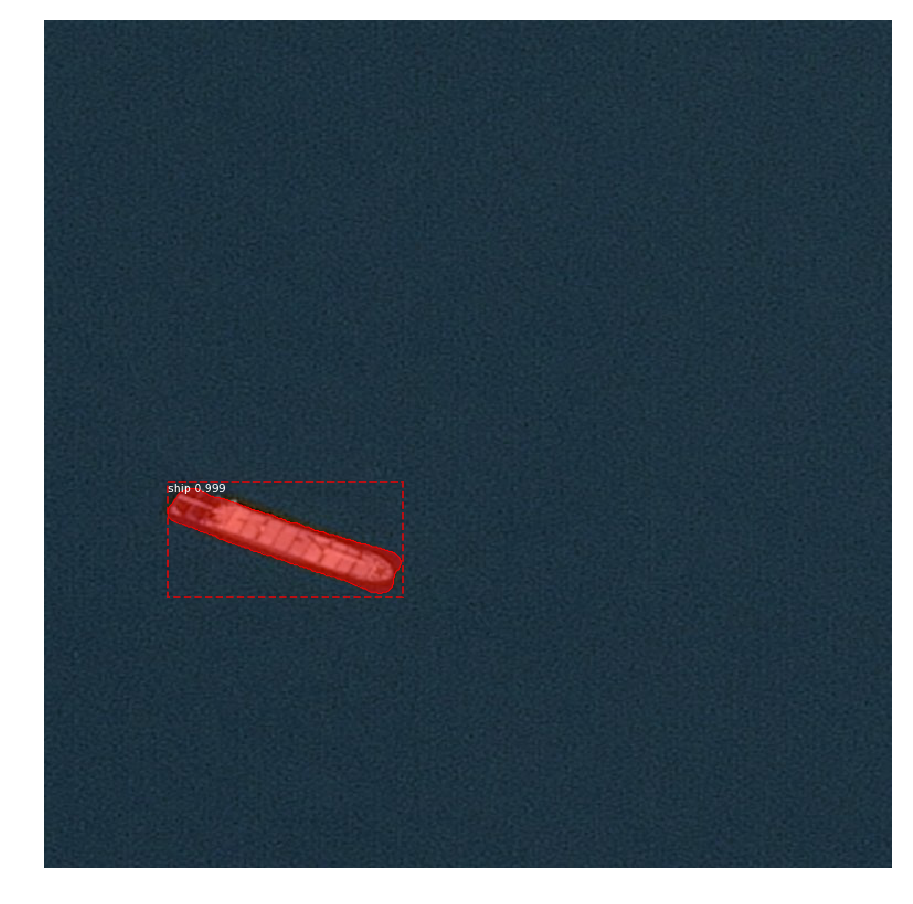

,ImageId,EncodedPixels
0,002deeb16.jpg,87227 8 87993 11 88760 13 89527 15 90293 17 91...


In [78]:
import pandas as pd
class_names = ['BG', 'ship']
# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# train: waves with ship 00119e4ba.jpg
# train: hard to see ship with waves 001eb2794.jpg
# train: lots of clouds no ships 0002d0f32.jpg
# train: two ships in train 0005d01c8.jpg
# train need to download - 15 ships 2053a78bd

# val: no ships in val 005b128fd.jpg
# val: single ship 002deeb16.jpg
# val: lots of land 00021ddc3.jpg
# val: clouds and no ships 00711596a.jpg

# test: 006da0c7b.jpg 1 small boat
# test: 0005d6d95.jpg 1 small boat
# test: 000194a2d.jpg land, dock, containers hard one
# test: with land and dock and containers (hard one) 013048d62.jpg
# test: land, dock, containers 0171499be.jpg
# test: had overlap 01834cb80.jpg
# test: had overlap 443cfdb6a.jpg

# 8904ed828.jpg CORRECT 4 Boats at sea (interesting because it seems like there are 2 pairs of ships touching each other)
# 890186275.jpg OCEAN NO BOATS - 3 False Positives caused by waves
# 89001e7f9.jpg CORRECT 0 Boats at sea
# 90fa78666.jpg CORRECT 3 Boats at sea
# 96f1f4dd8.jpg CORRECT 8 Boats at sea 6 with 55 - 8 with others back to normal
# 970ab9b85.jpg OCEAN NO BOATS - 5 False Positives caused by waves 2 with 55
# 97144e37a.jpg OCEAN NO BOATS - 5 False Positives caused by waves 1 with 55
# 56bbd97e1.jpg OCEAN NO BOATS - 9 False Positives caused by waves 1 with 55
# 61852516a.jpg OCEAN NO BOATS - 8 False Positives caused by waves 3 with 60 - 4 with 55
# 6186881a2.jpg OCEAN NO BOATS - 7 False Positives caused by waves 0 with 55
# 829a3bb7e.jpg CORRECT 5 Boats at sea - 3 with 55 - 4 with 64
# 8721fe1d6.jpg OCEAN NO BOATS - 8 False Positives caused by waves 0 with 55
# 87d888520.jpg OCEAN NO BOATS - 6 False Positives caused by waves 2 with 55
# 9754a98ad.jpg OCEAN NO BOATS - 7 False Positives caused by waves 2 with 60 - 2 with 55
# 9eed4be14.jpg OCEAN NO BOATS - 6 False Positives caused by waves 1 with 60 - 1 with 55

image_id = "002deeb16.jpg"
subset = "val"
image = skimage.io.imread(os.path.join(ROOT_DIR, SHIP_DIR, subset, image_id))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

out_pred_rows = []
re_encoded_to_rle_list = []
for i in np.arange(np.array(r['masks']).shape[-1]):
    boolean_mask = r['masks'][:,:,i]
    re_encoded_to_rle = dataset.rle_encode(boolean_mask)
    re_encoded_to_rle_list.append(re_encoded_to_rle)

if len(re_encoded_to_rle_list) == 0:
    out_pred_rows += [{'ImageId': image_id, 'EncodedPixels': ''}]
else:
    for rle_mask in re_encoded_to_rle_list:
        out_pred_rows += [{'ImageId': image_id, 'EncodedPixels': rle_mask}]
        
        
                
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.head()


In [ ]:

# 
# Compute mask overlap with ground truth
# 
train_val_csv_df = pd.read_csv(os.path.join(ROOT_DIR, "./samples/ship/datasets/train_val/train_ship_segmentations.csv"))
img_masks = train_val_csv_df.loc[train_val_csv_df['ImageId'] == image_id, 'EncodedPixels'].tolist()

# Mask array placeholder
mask_array = np.zeros([768, 768, len(img_masks)],dtype=np.uint8)

# Build mask array
for index, mask in enumerate(img_masks):
    mask_array[:,:,index] = rle_decode(mask, [768,768])

print("Overlap with ground truth")
print(utils.compute_overlaps_masks(r['masks'], mask_array))

all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)
    
# visualize.display_instances(image, r['rois'], mask_array, r['class_ids'], class_names, r['scores'])
fig, axarr = plt.subplots(1, 1, figsize=(100, 100))
axarr[0].axis('off')
# axarr[1].axis('off')
# axarr[2].axis('off')
# axarr[0].imshow(image)
# axarr[1].imshow(all_masks)
axarr[0].imshow(image)
axarr[0].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [ ]:
# image_id = "002deeb16.jpg" #random.choice(dataset.image_ids)
# image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
# info = dataset.image_info[image_id]
# print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                        dataset.image_reference(image_id)))

# # Run object detection
# results = model.detect([image], verbose=1)

# # Display results
# ax = get_ax(1)
# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset.class_names, r['scores'], ax=ax,
#                             title="Predictions")
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

## Color Splash

This is for illustration. You can call `balloon.py` with the `splash` option to get better images without the black padding.

In [ ]:
splash = balloon.color_splash(image, r['masks'])
display_images([splash], cols=1)

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [ ]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

In [ ]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

In [ ]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [ ]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

In [ ]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

#### Per-Class Non-Max Suppression

In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)